#Zadanie 2 (7 pkt)
Celem zadania jest rozwiązanie zadania optymalizacji przy pomocy algorytmu genetycznego. Należy znaleźć minimum zadanej funkcji:
\begin{equation}
f(x) = 1.5-\exp \left\{-x_1^2-x_2^2\right\}-0.5 \exp \left\{-\left(x_1-1\right)^2-\left(x_2+2\right)^2\right\}
\end{equation}
Należy wykorzystać mechanizmy krzyżowania punktowego, mutacji oraz selekcji turniejowej. Proszę wykorzystać przygotowany szkielet i zaimplementować niezbędne metody. Opracowane oprogramowanie powinno być uniwersalne - wymiar funkcji, której minimum szukamy może być dowolny (mechanizm *args). Punktacja wygląda następująco:

*   Stworzenie obiektu klasy *Chromosome* z polem *array*, które jest wektorem aktywnych i nieaktywnych genów - **0.5 pkt**
*   Implementacja metody *decode*, która dekoduje część chromosomu (określoną przez początek (*lower_bound*) i koniec (*upper_bound*)) do postaci liczby rzeczywistej. *aoi* to zakres wartości zdekodowanej liczby rzeczywistej. Przykład: liczba 135 w postaci binarnej zapisana przy użyciu 8 bitów to 1000 0111, jeśli nasze *aoi* to [0, 1], to 135 sprowadzone do tego zakresu to 0.529. Można skorzystać z funkcji pomocniczej *min_max_norm* - **1 pkt**
*   Implementacja metody *mutation*, która przyjmuje jako argument prawdopodobieństo mutacji i zmienia wartość jedego, losowego genu na przeciwną - **0.5 pkt**
*   Implementacja metody *crossover*, która wykonuje operację krzyżowania jednopunktowego - **1 pkt**
*   Implementacja metody *eval_objective_func*, która dekoduje cały chromosom (otrzymuje się argumenty funkcji) oraz zwraca wartość funkcji celu dla tych argumentów - **1 pkt**
*   Implementacja metody *tournament_selection*, która przeprowadza selekcję turniejową - **1 pkt**
*   Implementacja metody *reproduce*, która generuje nowe pokolenie - z pewnym prawdopodobieństwem przeprowadza krzyżowanie jednopunktowe lub "przerzuca" rodziców do nowego pokolenia - **0.5 pkt**
*   Implementacja metody *run*, która wykonuje cały alorytm genetyczny dla określonej liczby pokoleń. W każdym pokoleniu należy zapisać dane osobnika z najlepszym chromosomem zdekodowane wartości x i y oraz wartość funkcji strat dla tego osobnika - **0.5 pkt**
*   Proszę, podobnie jak miało to miejsce w przypadku metody gradientowej z poprzednich zajęć, wygenerować wykres przy użyciu funkcji *plot_func* (w przypadku innego typu argumentu *trace*, funkcję można zmodyfikować. Wykres powinien przedstawiać funkcję, której minimum poszukujemy oraz punkty odpowiadające najlepszym osobnikom w danych generacjach, których kolor jest coraz jaśniejszy wraz ze zbliżaniem się do minimum. Proszę zapisać swoje wnioski, w szczególności w odniesieniu do metody gradientowej. - **1 pkt**


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from random import uniform

In [ ]:
def min_max_norm(val, min_val, max_val, new_min, new_max):
  return (val - min_val) * (new_max - new_min) / (max_val - min_val) + new_min

def function(x, y):
    return 1.5 - np.exp(-x ** (2) - y ** (2)) - 0.5 * np.exp(-(x - 1) ** (2) - (y + 2) ** (2))

In [ ]:
class Chromosome:
    #  if array is None it should be initialized with random binary vector
    def __init__(self, length, array=None):
        if length % 2 == 0:
            self.length = length
        else:
            raise ValueError("Length should be even")

        if array is None:
            self.array = np.random.randint(2, size=length)
        elif len(array) == length:
            self.array = array
        else:
            raise ValueError("Wrong length of array")

    # decode part of the chromosome to the new value in the range of aoi
    def decode(self, lower_bound: int, upper_bound: int, aoi: list) -> float:

        array = self.array[lower_bound:upper_bound]
        length = len(array)
        value = 0
        aoi_low = aoi[0]
        aoi_high = aoi[1]
        for i in range(length):
            value += array[i] * 2 ** (length - 1)
            length -= 1

        min_value = 0
        max_value = 2 ** len(array) - 1

        new_value = min_max_norm(value, min_value, max_value, aoi_low, aoi_high)
        return new_value

    # mutate one of the bits in the chromosome with some probability
    def mutation(self, probability):
        random_value = uniform(0, 1)
        if random_value <= probability:
            random_index = np.random.randint(0, self.length)
            self.array[random_index] = 1 - self.array[random_index]

    # crossover two chromosomes with the same length and returns both possible children
    def crossover(self, other):
        random_index = np.random.randint(0, self.length)
        first_part_1 = self.array[:random_index]
        second_part_1 = other.array[random_index:]
        first_combination = np.concatenate((first_part_1, second_part_1), axis=None)

        first_part_2 = other.array[:random_index]
        second_part_2 = self.array[random_index:]
        second_combination = np.concatenate((first_part_2, second_part_2), axis=None)

        Child_one = Chromosome(self.length, first_combination)
        Child_two = Chromosome(self.length, second_combination)
        return Child_one, Child_two

In [ ]:
class GeneticAlgorithm:
    def __init__(self, chromosome_length, obj_func_num_args, objective_function, aoi, population_size=1000,
                tournament_size=2, mutation_probability=0.05, crossover_probability=0.8, num_steps=30, list_of_chromosomes=None):
        assert chromosome_length % obj_func_num_args == 0, "Number of bits for each argument should be equal"
        self.chromosome_lengths = chromosome_length
        self.obj_func_num_args = obj_func_num_args
        self.bits_per_arg = int(chromosome_length / obj_func_num_args)
        self.objective_function = objective_function
        self.aoi = aoi
        self.tournament_size = tournament_size
        self.mutation_probability = mutation_probability
        self.crossover_probability = crossover_probability
        self.num_steps = num_steps
        self.population_size = population_size
        if list_of_chromosomes is None:
            self.list_of_chromosomes = np.array([Chromosome(chromosome_length) for _ in range(population_size)])
        else:
            self.list_of_chromosomes = list_of_chromosomes

    def eval_objective_func(self, chromosome):
         # arguments list for the objective function
        args = []

        # decode each argument from the chromosome
        for i in range(self.obj_func_num_args):
            lower_bound = i * self.bits_per_arg
            upper_bound = (i + 1) * self.bits_per_arg
            value = chromosome.decode(lower_bound, upper_bound, self.aoi)
            args.append(value)

        # evaluate the objective function
        return self.objective_function(*args)

      # tournament selection which chenges the list of chromosomes so the better one have more chance to be chosen
    def tournament_selection(self):
        winners = []
        i = 0
        chromosomes = self.list_of_chromosomes
        while len(winners) < len(chromosomes):
            while True:
                random_index = np.random.randint(0, len(chromosomes))
                if random_index != i:
                    break
            first_chromosome = chromosomes[i]
            second_chromosome = chromosomes[random_index]
            if self.eval_objective_func(first_chromosome) < self.eval_objective_func(second_chromosome):
                winners.append(first_chromosome)
            else:
                winners.append(second_chromosome)
            i += 1
        self.list_of_chromosomes = winners

    def choose_parents(self):
        indexes = np.random.choice(np.arange(len(ga.list_of_chromosomes)), 2, replace=False)
        parents = self.list_of_chromosomes[indexes[0]], self.list_of_chromosomes[indexes[1]]
        modified_list_of_chromosomes = np.delete(self.list_of_chromosomes, indexes, axis=0)
        self.list_of_chromosomes = modified_list_of_chromosomes
        return parents

    # choose two parents for mutation and then crossover them
    def reproduce(self, parents):
        first_parent = parents[0]
        second_parent = parents[1]
        if np.random.uniform(0, 1) < self.crossover_probability:
            first_child, second_child = first_parent.crossover(second_parent)
            return first_child, second_child
        else:
            return first_parent, second_parent


    def plot_func(self, trace):
        X = np.arange(-2, 3, 0.05)
        Y = np.arange(-4, 2, 0.05)
        X, Y = np.meshgrid(X, Y)
        Z = 1.5 - np.exp(-X ** (2) - Y ** (2)) - 0.5 * np.exp(-(X - 1) ** (2) - (Y + 2) ** (2))
        plt.figure()
        plt.contour(X, Y, Z, 10)
        cmaps = [[ii / len(trace), 0, 0] for ii in range(len(trace))]
        plt.scatter([x[0] for x in trace], [x[1] for x in trace], c=cmaps)
        plt.show()

    def show_pop(self):
        X = np.arange(-2, 3, 0.05)
        Y = np.arange(-4, 2, 0.05)
        X, Y = np.meshgrid(X, Y)
        Z = 1.5 - np.exp(-X ** (2) - Y ** (2)) - 0.5 * np.exp(-(X - 1) ** (2) - (Y + 2) ** (2))
        plt.figure()
        plt.contour(X, Y, Z, 10)

        points = [[chromosome.decode(0, self.bits_per_arg, self.aoi), chromosome.decode(self.bits_per_arg, 2* self.bits_per_arg, self.aoi)] for chromosome in self.list_of_chromosomes]
        plt.scatter([x[0] for x in points], [x[1] for x in points])
        plt.show()

    def run(self):
        # variables for the best individual and its value
        best_individual = None
        x_value = None
        y_value = None
        function_value = None

        # initialize the trace list
        trace = []

        # run the algorithm for num_steps iterations
        for generation in range(self.num_steps):

            # tournament selection to choose better chromosomes
            self.tournament_selection()

            new_generation = []  # list of new chromosomes in the generation

            # create new generation
            while len(new_generation) < self.population_size:
                # choose parents for crossover
                parents = self.choose_parents()
                first_child, second_child = self.reproduce(parents)
                new_generation.append(first_child)
                new_generation.append(second_child)

            # set list of chromosomes to the new generation
            self.list_of_chromosomes = new_generation

            # mutate the chromosomes with the given probability
            for chromosome in self.list_of_chromosomes:
                if np.random.uniform(0, 1) < self.mutation_probability:
                    chromosome.mutation(self.mutation_probability)

            # find the best individual in the generation
            best_individual = min(self.list_of_chromosomes, key=self.eval_objective_func)  # returns Chromosome with the lowest eval_objective_func value

            x_value = best_individual.decode(0, self.bits_per_arg, self.aoi)
            y_value = best_individual.decode(self.bits_per_arg, 2 * self.bits_per_arg, self.aoi)
            function_value = self.eval_objective_func(best_individual)

            trace.append((x_value, y_value))

            print("Generation: ", generation, "Best individual: ", best_individual.array, "x: ", x_value, "y: ", y_value, "Function value: ", function_value)
            #self.show_pop()

        # plot the function
        self.plot_func(trace)

# Pierwsze badanie działalności alorytmu genetycznego
Polegać będzie na przedstawieniu całych populacji z 15 pokoleń, aby sprawdzić, czy pojawia się zagęszczenie w minimach funkcji

Generation:  0 Best individual:  [1 0 0 0 0 1 1 0 1 0 1 0 0 1 1 1 0 1 1 1 1 1 1 1 1 0 0 0 1 1 1 0] x:  0.41589990081635797 y:  -0.027710383764400603 Function value:  0.6522168937915938


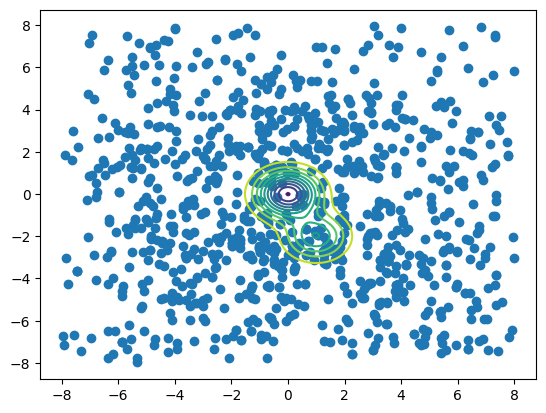

Generation:  1 Best individual:  [1 0 0 0 0 0 0 1 1 1 1 0 0 0 0 1 1 0 0 0 0 0 1 1 1 0 1 1 0 0 1 1] x:  0.11755550469214882 y:  0.23132677195391693 Function value:  0.5635351886676946


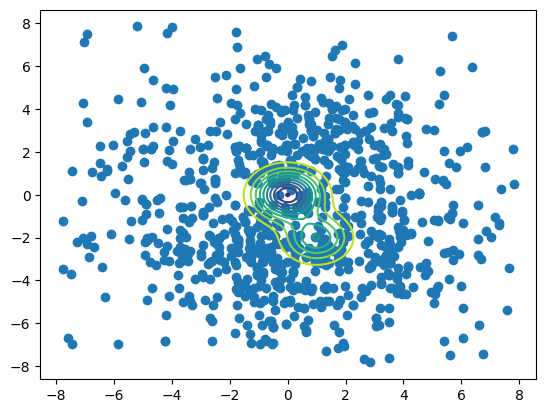

Generation:  2 Best individual:  [0 1 1 1 1 1 0 1 0 1 0 0 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0] x:  -0.16833752956435521 y:  -0.007690547035934969 Function value:  0.5255856528103278


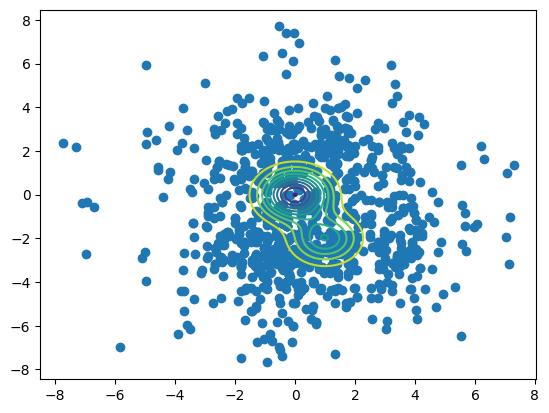

Generation:  3 Best individual:  [0 1 1 1 1 1 0 1 0 1 0 0 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0] x:  -0.16833752956435521 y:  -0.004272526131074983 Function value:  0.5255785569904595


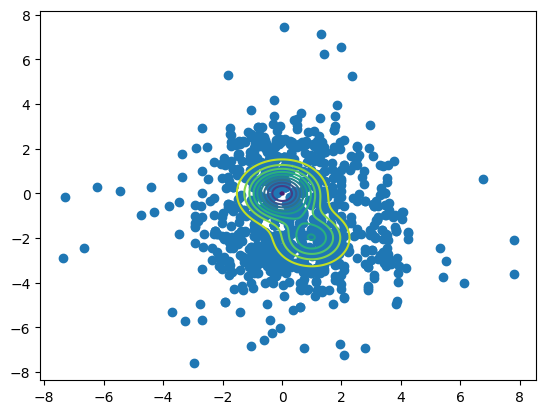

Generation:  4 Best individual:  [1 0 0 0 0 0 0 1 1 1 0 0 1 1 1 0 0 1 1 1 1 1 1 0 0 0 1 0 0 0 1 0] x:  0.11291676203555312 y:  -0.11657892729076025 Function value:  0.5194407126725971


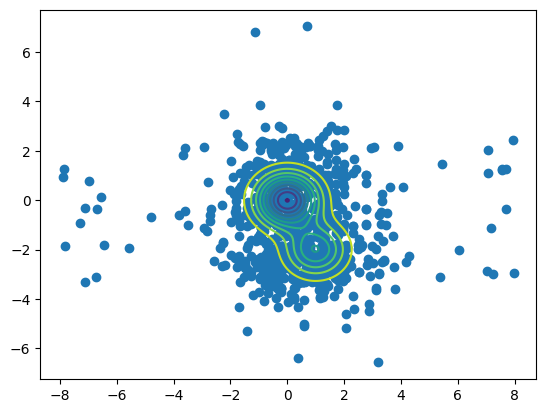

Generation:  5 Best individual:  [1 0 0 0 0 0 0 1 1 0 0 1 0 1 0 0 1 0 0 0 0 0 0 1 0 1 0 0 0 0 1 1] x:  0.09875638971541889 y:  0.0789806973373004 Function value:  0.5129183113028428


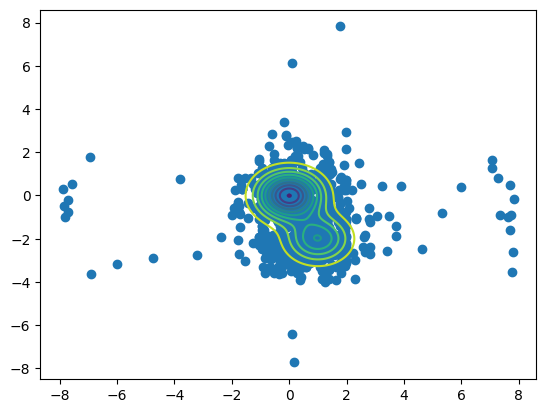

Generation:  6 Best individual:  [1 0 0 0 0 0 0 0 0 0 0 1 0 1 1 1 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0] x:  0.005737392233157834 y:  -0.03112840466926059 Function value:  0.49714553144573137


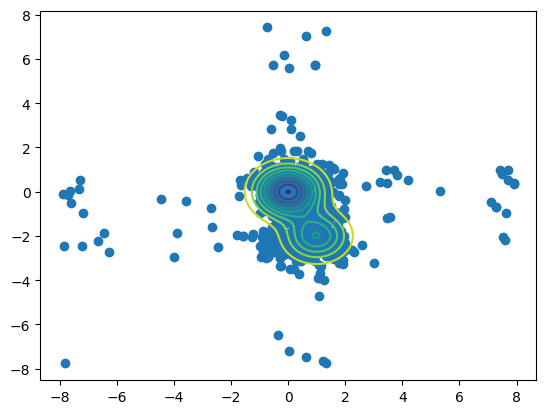

Generation:  7 Best individual:  [1 0 0 0 0 0 0 0 0 0 0 1 0 1 1 1 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0] x:  0.005737392233157834 y:  -0.03112840466926059 Function value:  0.49714553144573137


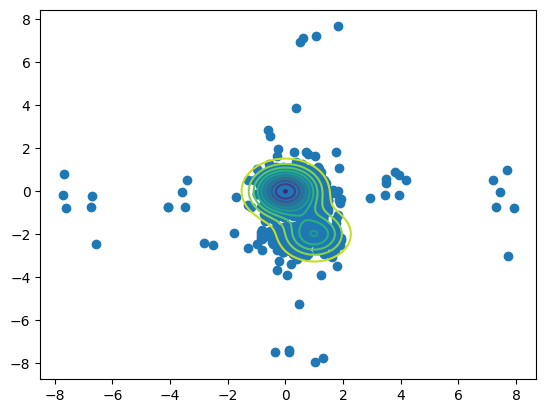

Generation:  8 Best individual:  [1 0 0 0 0 0 0 0 0 0 0 1 0 1 1 1 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0] x:  0.005737392233157834 y:  -0.03112840466926059 Function value:  0.49714553144573137


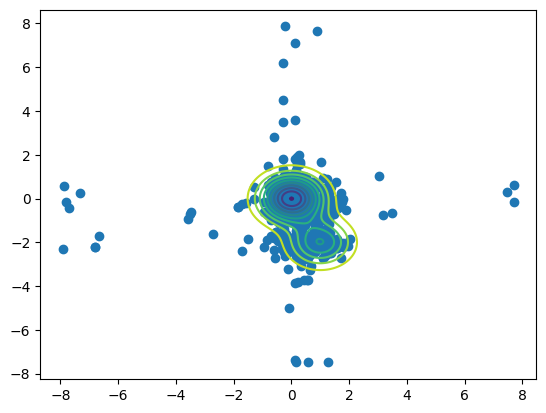

Generation:  9 Best individual:  [1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 1 0 1 1 1 1 1 1 1 1 0 0 0 1 0 0 0] x:  0.0072022583352406855 y:  -0.029175249866483455 Function value:  0.4970652006340913


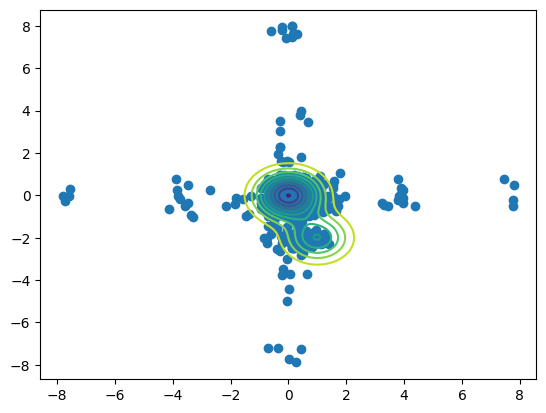

Generation:  10 Best individual:  [1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 1 0 1 1 1 1 1 1 1 1 0 0 0 1 0 0 0] x:  0.0072022583352406855 y:  -0.029175249866483455 Function value:  0.4970652006340913


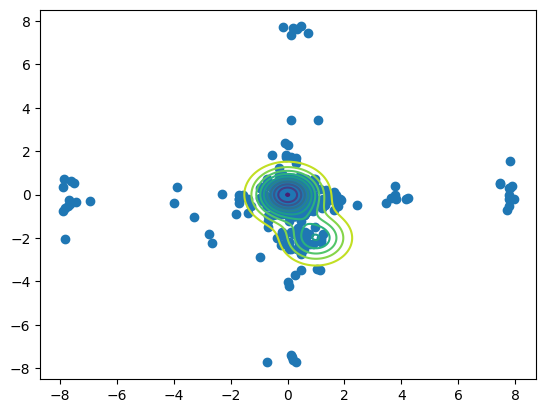

Generation:  11 Best individual:  [1 0 0 0 0 0 0 0 0 1 0 1 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0] x:  0.021118486305027773 y:  -0.007690547035934969 Function value:  0.4968827329880597


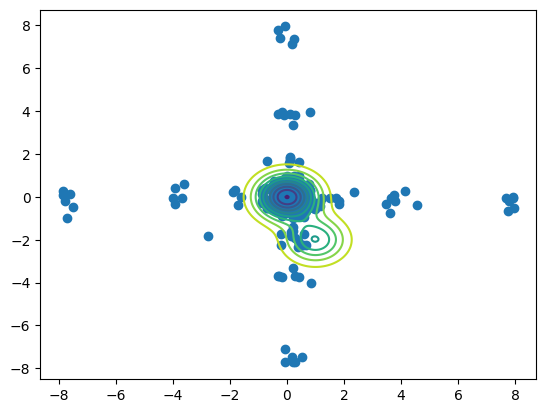

Generation:  12 Best individual:  [1 0 0 0 0 0 0 0 0 1 0 1 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 1 0] x:  0.021118486305027773 y:  -0.0072022583352406855 Function value:  0.4968825063136656


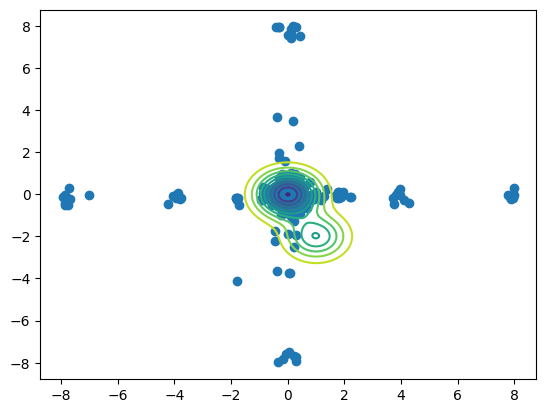

Generation:  13 Best individual:  [1 0 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1] x:  0.010131990539406388 y:  -0.0035400930800335573 Function value:  0.4966286169804285


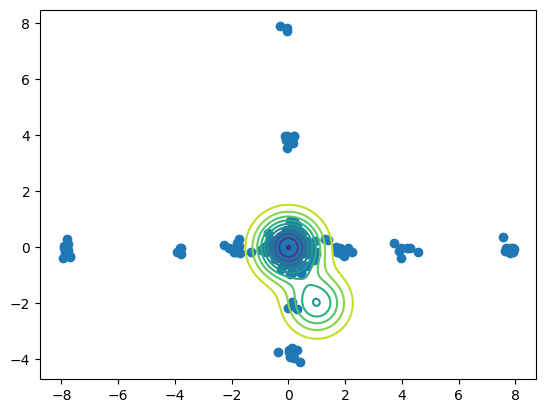

Generation:  14 Best individual:  [1 0 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1] x:  0.010131990539406388 y:  -0.0035400930800335573 Function value:  0.4966286169804285


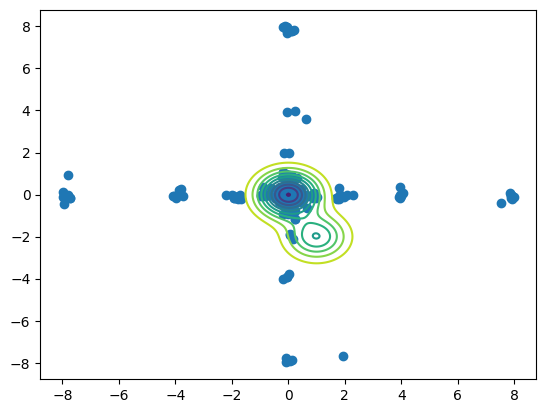

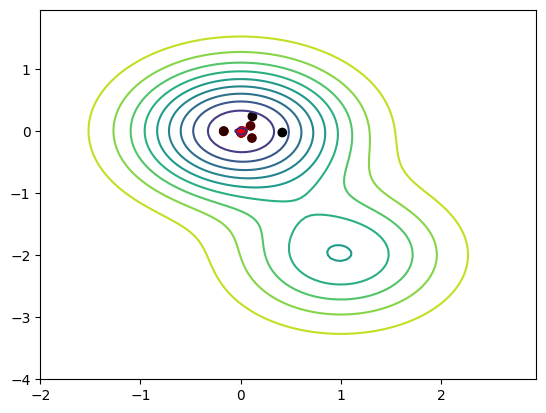

In [ ]:
ga = GeneticAlgorithm(chromosome_length=32, obj_func_num_args=2, objective_function=function, population_size=1000, num_steps=15, aoi=[-8, 8])
ga.run()

# Badanie wpływu wielkości pokoleń, na poprawne działanie algorytmu genetycznego
## Badanie nr 1 :


*   Rozmiar populacji : 30
*   Ilość generacji : 20
*   Prawdopodobieństwo mutacji : 0.05
*   Długość chromosomu : 32



Generation:  0 Best individual:  [1 0 0 0 1 1 0 0 1 0 0 0 1 0 1 0 1 0 0 0 0 0 1 1 0 0 0 1 0 0 1 0] x:  0.7838254367895026 y:  0.1920195315480271 Function value:  0.9747007480568883
Generation:  1 Best individual:  [1 0 0 0 1 0 0 0 0 1 0 0 1 0 0 1 1 0 0 0 0 1 1 1 0 0 1 1 0 1 1 1] x:  0.5179522392614633 y:  0.4510566872663464 Function value:  0.8751010852368215
Generation:  2 Best individual:  [1 0 0 0 1 0 0 0 0 1 0 0 1 0 0 1 1 0 0 0 0 0 1 0 0 1 1 1 0 0 0 0] x:  0.5179522392614633 y:  0.1524681467917901 Function value:  0.7490196911319787
Generation:  3 Best individual:  [1 0 0 0 1 0 0 0 0 1 0 0 1 0 0 1 1 0 0 0 0 0 1 0 0 1 1 1 0 0 0 0] x:  0.5179522392614633 y:  0.1524681467917901 Function value:  0.7490196911319787
Generation:  4 Best individual:  [1 0 0 0 1 0 0 0 0 1 0 0 1 0 0 1 1 0 0 0 0 0 1 0 0 1 1 1 0 0 0 0] x:  0.5179522392614633 y:  0.1524681467917901 Function value:  0.7490196911319787
Generation:  5 Best individual:  [1 0 0 0 1 0 0 0 0 1 0 0 1 0 0 1 1 0 0 0 0 0 1 0 0 0 0 1 0 0 1

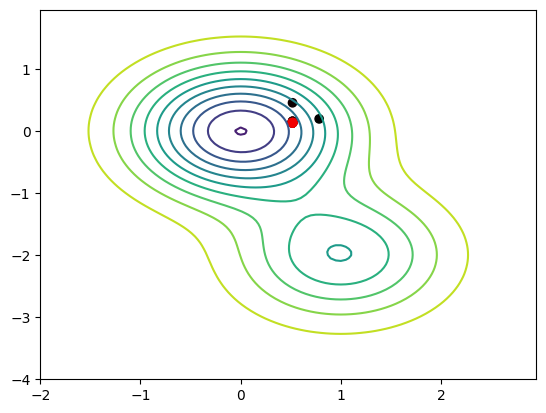

In [ ]:
ga = GeneticAlgorithm(chromosome_length=32, obj_func_num_args=2, objective_function=function, population_size=30, num_steps=20, aoi=[-8, 8])
ga.run()

## Badanie nr 2 :
Zwiększamy populację 10-krotnie

*   Rozmiar populacji : 300
*   Ilość generacji : 20
*   Prawdopodobieństwo mutacji : 0.05
*   Długość chromosomu : 32


Generation:  0 Best individual:  [1 0 0 0 0 1 1 1 1 0 0 0 0 0 0 1 1 0 0 0 0 0 1 1 0 1 1 1 1 1 1 1] x:  0.4691233691920349 y:  0.21863126573586555 Function value:  0.7322507981753454
Generation:  1 Best individual:  [1 0 0 0 0 1 1 1 1 0 1 1 0 1 0 0 1 0 0 0 0 0 1 0 1 0 1 1 0 0 1 0] x:  0.48157473105973914 y:  0.16858167391470147 Function value:  0.7257395726416193
Generation:  2 Best individual:  [1 0 0 0 0 0 0 1 0 0 1 1 0 1 1 1 0 1 1 1 0 1 1 1 1 0 1 0 1 1 1 0] x:  0.0760509651331347 y:  -0.5199053940642404 Function value:  0.717438497514158
Generation:  3 Best individual:  [1 0 0 0 0 1 1 1 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 1 1 0 1 0 1 1] x:  0.4691233691920349 y:  0.05749599450675191 Function value:  0.6947200087575374
Generation:  4 Best individual:  [0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 1 0 1 1 0 0 1 0] x:  -0.06237888151369475 y:  0.16858167391470147 Function value:  0.5303274951984893
Generation:  5 Best individual:  [0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 1 1 1 

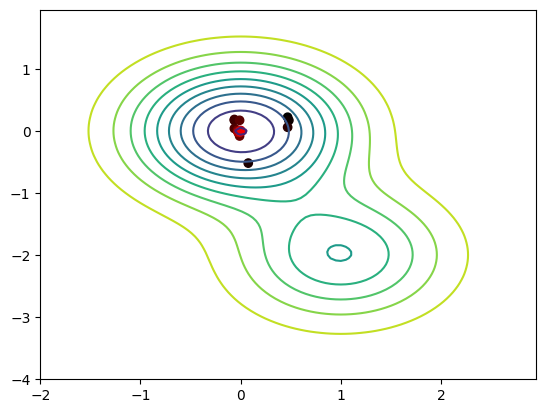

In [ ]:
ga = GeneticAlgorithm(chromosome_length=32, obj_func_num_args=2, objective_function=function, population_size=300, num_steps=20, aoi=[-8, 8])
ga.run()

## Badanie nr 3 :
Zwiększamy populację 30-krotnie

*   Rozmiar populacji : 1000
*   Ilość generacji : 20
*   Prawdopodobieństwo mutacji : 0.05
*   Długość chromosomu : 32

Generation:  0 Best individual:  [1 0 0 0 0 0 1 0 0 0 1 0 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0] x:  0.13586633096818446 y:  -0.0028076600289921316 Function value:  0.5139090519343809
Generation:  1 Best individual:  [1 0 0 0 0 0 1 0 0 0 1 0 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 1 1 0] x:  0.13586633096818446 y:  -0.006225680933852118 Function value:  0.5138790810125808
Generation:  2 Best individual:  [1 0 0 0 0 0 0 1 0 1 1 1 0 1 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0] x:  0.09143205920500463 y:  0.01672388799877922 Function value:  0.5048516165673731
Generation:  3 Best individual:  [1 0 0 0 0 0 0 1 0 1 1 1 0 1 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0] x:  0.09143205920500463 y:  0.01672388799877922 Function value:  0.5048516165673731
Generation:  4 Best individual:  [1 0 0 0 0 0 0 1 0 1 1 1 0 1 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0] x:  0.09143205920500463 y:  0.01672388799877922 Function value:  0.5048516165673731
Generation:  5 Best individual:  [1 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0 0 0 0 0 

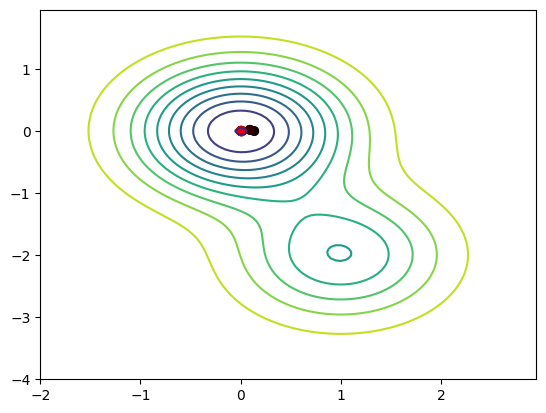

In [ ]:
ga = GeneticAlgorithm(chromosome_length=32, obj_func_num_args=2, objective_function=function, population_size=1000, num_steps=20, aoi=[-8, 8])
ga.run()

# **Wnioski**
Jak widizmy rozmiar populacji ma znaczenie na działanie algorytmu. Jak widzieliśmy w badaniu nr 1, zbyt mała populacjia sprawiła, że algorytm nie znalazł minimum funkcji, ponieważ nie zdążył wyewoluować na tyle, żeby kolejne pokolenia miały chromosomy o dobrych wartościach

Zwiększenie rozmiaru pokolenia zaskutkowało poprawieniem się algorytmu i znalezieniem minimum

Przy dużych pokoleniach zwiększa się zagęszczenie wokół minimum

---------------------------------------------------------------------------------------------------------------------------------------------------------------

# Badanie wpływu szansy na mutację, na poprawne działanie algorytmu genetycznego
## Badanie nr 1 :


*   Rozmiar populacji : 800
*   Ilość generacji : 20
*   Prawdopodobieństwo mutacji : 0.05
*   Długość chromosomu : 16





Generation:  0 Best individual:  [1 0 0 0 0 0 0 1 0 1 0 0 0 0 1 1 1 0 0 0 0 1 0 0 1 0 0 0 0 0 1 1] x:  0.0789806973373004 y:  0.2821087968261242 Function value:  0.5810721069317224
Generation:  1 Best individual:  [0 1 1 1 1 1 1 1 1 0 0 0 0 1 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 1 1 0] x:  -0.030151827267872022 y:  -0.006225680933852118 Function value:  0.4976987285203974
Generation:  2 Best individual:  [0 1 1 1 1 1 1 1 1 0 0 0 0 1 0 0 0 1 1 1 1 1 1 0 0 0 0 0 1 1 0 0] x:  -0.030151827267872022 y:  -0.12195010299839737 Function value:  0.5105719466043063
Generation:  3 Best individual:  [0 1 1 1 1 1 1 0 0 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1] x:  -0.09753566796368318 y:  -0.0050049591821164086 Function value:  0.5066917940459581
Generation:  4 Best individual:  [1 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 1 0 0 1 1] x:  0.03918516823071627 y:  0.020386053253986347 Function value:  0.4985974146166154
Generation:  5 Best individual:  [0 1 1 1 1 1 1 1 1 0 0 0 1 0 1 1 1 0 0 0 0

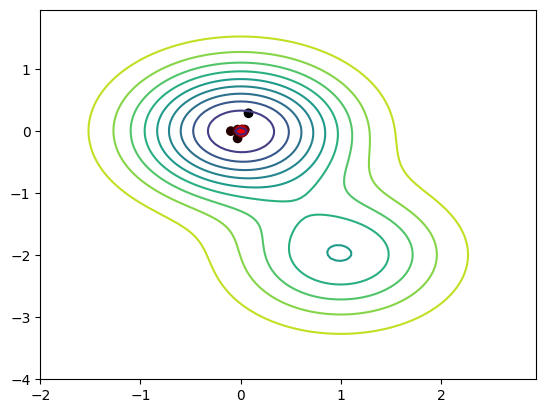

In [ ]:
ga = GeneticAlgorithm(chromosome_length=32, obj_func_num_args=2, objective_function=function,population_size=800, num_steps=20, aoi=[-8, 8])
ga.run()

## Badanie nr 2 :

*   Rozmiar populacji : 800
*   Ilość generacji : 20
*   Prawdopodobieństwo mutacji : 0.25
*   Długość chromosomu : 16

Generation:  0 Best individual:  [0 1 1 1 1 1 1 0 1 0 0 1 1 0 0 0 0 1 1 1 1 1 1 0 1 0 1 1 0 0 0 0] x:  -0.0877698939497975 y:  -0.0819104295414661 Function value:  0.5104432076840276
Generation:  1 Best individual:  [0 1 1 1 1 1 1 0 1 0 0 1 1 0 0 0 0 1 1 1 1 1 1 0 1 0 1 1 0 0 1 1] x:  -0.0877698939497975 y:  -0.08117799649042468 Function value:  0.5103363087145713
Generation:  2 Best individual:  [0 1 1 1 1 1 1 0 1 0 0 1 1 0 0 0 0 1 1 1 1 1 1 0 1 0 1 1 0 0 1 1] x:  -0.0877698939497975 y:  -0.08117799649042468 Function value:  0.5103363087145713
Generation:  3 Best individual:  [0 1 1 1 1 1 1 0 1 0 0 1 1 0 0 0 0 1 1 1 1 1 1 0 1 0 1 1 0 0 1 1] x:  -0.0877698939497975 y:  -0.08117799649042468 Function value:  0.5103363087145713
Generation:  4 Best individual:  [1 0 0 0 0 0 1 1 1 0 0 1 1 1 0 0 1 0 0 0 0 0 0 1 1 0 0 1 1 1 1 1] x:  0.22571145189593267 y:  0.10144197756923745 Function value:  0.5560820067821941
Generation:  5 Best individual:  [1 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 

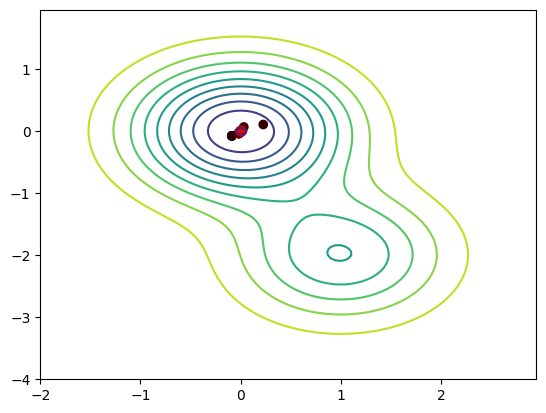

In [ ]:
ga = GeneticAlgorithm(chromosome_length=32, obj_func_num_args=2, objective_function=function, mutation_probability=0.25, population_size=800, num_steps=20, aoi=[-8, 8])
ga.run()

## Badanie nr 3 :

*   Rozmiar populacji : 800
*   Ilość generacji : 20
*   Prawdopodobieństwo mutacji : 0.80
*   Długość chromosomu : 16

Generation:  0 Best individual:  [1 0 0 0 0 1 0 1 1 0 0 1 0 0 0 1 0 1 1 1 1 0 1 0 1 1 1 1 1 0 1 1] x:  0.3480277714198525 y:  -0.31360341802090463 Function value:  0.67803389931982
Generation:  1 Best individual:  [0 1 1 1 1 1 1 0 1 1 0 0 1 0 0 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0] x:  -0.07580682078278755 y:  -0.031616693369954874 Function value:  0.5034603626123874
Generation:  2 Best individual:  [0 1 1 1 1 1 0 0 0 1 1 0 0 1 0 0 0 1 1 1 1 1 0 1 0 1 1 1 0 0 1 0] x:  -0.22546730754558642 y:  -0.1595483329518581 Function value:  0.5696892703788855
Generation:  3 Best individual:  [1 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0 0 0 0 0 0 1 0 1 1 1 0 1 0 1] x:  0.035278858625162 y:  0.09118791485465749 Function value:  0.5070278378838778
Generation:  4 Best individual:  [1 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1] x:  0.035278858625162 y:  0.006225680933852118 Function value:  0.4977607073612462
Generation:  5 Best individual:  [1 0 0 0 0 0 0 0 0 1 1 0 0 1 0 1 0 1 1 1 1 1 1 0 1 0 

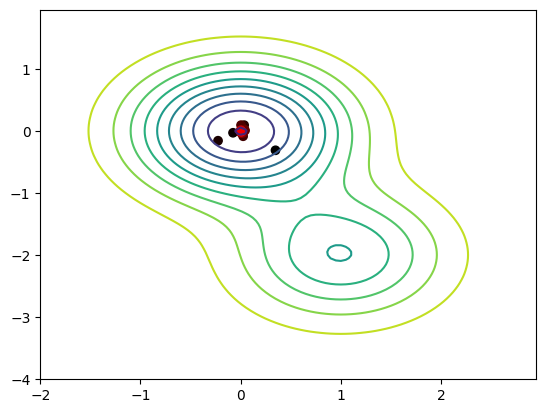

In [ ]:
ga = GeneticAlgorithm(chromosome_length=32, obj_func_num_args=2, objective_function=function, mutation_probability=0.80, population_size=800, num_steps=20, aoi=[-8, 8])
ga.run()

# **Wnioski**

Jak widać mutacja ma bardzo mały wpływ na poprawne działanie algorytmu. Wynika to z tego, gdyż mutacja ma wpływ na tylko jeden gen (bit) chromosomu, który niekoniecznie dużo zmienia w naszym algorytmie.

Jeżeli trafi na bity końcowe, to wynik ulegnie tylko niewielkiej zmianie, natomiast mutacja bitów na początkowych pozycjach zwiększa wynik dekodowania chromosomu bardzo.

Natomiast populacje są tak duże, że udaje się znaleźć zawsze takie chormosomy co dadzą nam mały wynik

Dodatkowo w selekcji turniejowej odrzucane są te chromosomy, które dały nam duże wyniki, ponieważ odpadają one w selekcji następnych pokoleń

# Badanie dużej mutacji i małego pokolenia

*   Rozmiar populacji : 30
*   Ilość generacji : 20
*   Prawdopodobieństwo mutacji : 0.80
*   Długość chromosomu : 16

Generation:  0 Best individual:  [1 0 0 0 1 0 0 1 0 1 1 0 0 1 1 0 0 1 1 1 1 0 1 0 1 0 1 1 1 0 1 0] x:  0.5875333791103987 y:  -0.32947280079346886 Function value:  0.8388680750131493
Generation:  1 Best individual:  [1 0 0 0 1 0 0 1 0 1 1 0 0 1 1 0 0 1 1 1 1 0 1 0 1 0 0 1 1 0 1 0] x:  0.5875333791103987 y:  -0.3372854200045774 Function value:  0.8414854934671671
Generation:  2 Best individual:  [1 0 0 0 1 0 0 0 1 0 0 0 1 1 1 1 0 1 1 1 1 0 1 1 0 0 1 0 1 1 0 0] x:  0.5350423437857632 y:  -0.3016403448538947 Function value:  0.7917494863192749
Generation:  3 Best individual:  [1 0 0 0 1 0 0 0 1 0 0 0 1 1 1 1 0 1 1 1 1 1 0 0 0 0 0 0 0 1 1 0] x:  0.5350423437857632 y:  -0.24841687647821775 Function value:  0.7751531569261355
Generation:  4 Best individual:  [1 0 0 0 0 0 1 1 1 0 1 1 1 1 1 0 0 1 1 1 1 0 1 1 1 1 0 0 0 0 1 0] x:  0.2340123598077355 y:  -0.2650186923018234 Function value:  0.6037958609074127
Generation:  5 Best individual:  [1 0 0 0 0 0 0 0 1 1 0 0 1 1 1 1 0 1 1 1 1 1 0 0 0 0 0 

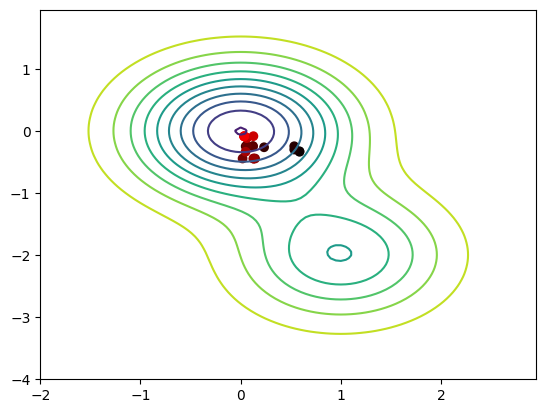

In [ ]:
ga = GeneticAlgorithm(chromosome_length=32, obj_func_num_args=2, objective_function=function, mutation_probability=0.80, population_size=30, num_steps=20, aoi=[-8, 8])
ga.run()

Generation:  0 Best individual:  [1 0 0 0 0 0 1 1 1 1 0 1 1 0 1 0 1 0 0 0 1 0 1 1 0 0 0 0 1 0 1 0] x:  0.24084840161745547 y:  0.6900740062561983 Function value:  0.9136656390968401
Generation:  1 Best individual:  [1 0 0 0 0 1 0 1 1 1 1 0 1 0 1 0 0 1 1 0 0 0 1 1 0 0 0 0 0 1 0 1] x:  0.36975661860074815 y:  -1.8111848630502783 Function value:  1.1428665706561048
Generation:  2 Best individual:  [1 0 0 0 0 1 0 1 1 1 1 0 1 0 1 0 0 1 1 0 0 0 1 1 1 0 1 0 1 0 0 1] x:  0.36975661860074815 y:  -1.771145189593347 Function value:  1.1431853902207876
Generation:  3 Best individual:  [1 0 0 0 1 1 0 1 0 1 0 1 0 1 0 0 0 1 0 1 1 1 0 1 1 0 1 0 1 0 0 0] x:  0.8331425955596252 y:  -2.146395056076906 Function value:  1.019053430226442
Generation:  4 Best individual:  [1 0 0 0 1 1 0 1 0 1 0 1 0 1 0 0 0 1 0 1 1 1 0 1 1 0 0 0 1 1 0 1] x:  0.8331425955596252 y:  -2.1529869535362787 Function value:  1.0201311328343832
Generation:  5 Best individual:  [1 0 0 0 1 0 0 0 0 1 0 1 0 1 0 0 0 1 1 1 0 0 1 0 0 0 0 0 1

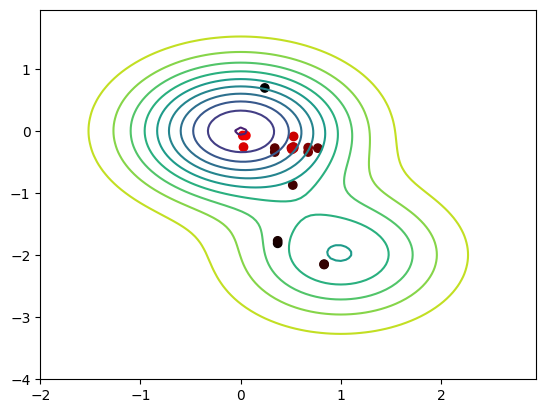

In [ ]:
ga = GeneticAlgorithm(chromosome_length=32, obj_func_num_args=2, objective_function=function, mutation_probability=0.80, population_size=30, num_steps=20, aoi=[-8, 8])
ga.run()

# Przy małym rozmiarze pokolenia i dużej mutacji, algorytm nie zawsze znajduje najlepsze rozwiązania i tworzą się grupy poza minimum. Czsaem uda mu się znaleźć dobry punkt

--------------------------------------------------------------------------------

# Badanie wpływu długości chromosomu, na poprawne działanie algorytmu genetycznego

## Badanie nr 1:
*  Rozmiar populacji : 1000
*  Ilość generacji :  20
*  Prawdopodobieństwo mutacji : 0.05
*  Długość chromoosmu : 8

Generation:  0 Best individual:  [1 0 0 0 0 1 1 1] x:  0.5333333333333332 y:  -0.5333333333333332 Function value:  0.8870535247441871
Generation:  1 Best individual:  [1 0 0 0 0 1 1 1] x:  0.5333333333333332 y:  -0.5333333333333332 Function value:  0.8870535247441871
Generation:  2 Best individual:  [1 0 0 0 0 1 1 1] x:  0.5333333333333332 y:  -0.5333333333333332 Function value:  0.8870535247441871
Generation:  3 Best individual:  [1 0 0 0 0 1 1 1] x:  0.5333333333333332 y:  -0.5333333333333332 Function value:  0.8870535247441871
Generation:  4 Best individual:  [1 0 0 0 0 1 1 1] x:  0.5333333333333332 y:  -0.5333333333333332 Function value:  0.8870535247441871
Generation:  5 Best individual:  [1 0 0 0 0 1 1 1] x:  0.5333333333333332 y:  -0.5333333333333332 Function value:  0.8870535247441871
Generation:  6 Best individual:  [1 0 0 0 0 1 1 1] x:  0.5333333333333332 y:  -0.5333333333333332 Function value:  0.8870535247441871
Generation:  7 Best individual:  [1 0 0 0 0 1 1 1] x:  0.53333

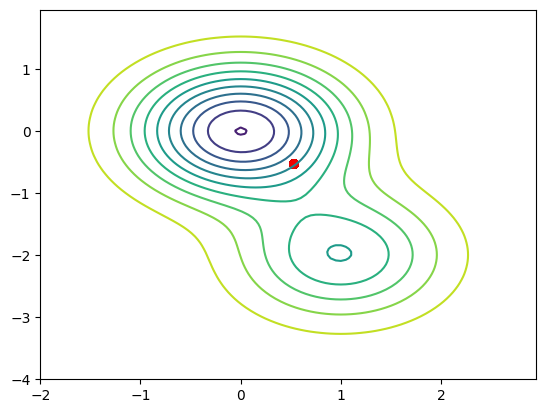

In [ ]:
ga = GeneticAlgorithm(chromosome_length=8, obj_func_num_args=2, objective_function=function, mutation_probability=0.1, population_size=1000, num_steps=20, aoi=[-8, 8])
ga.run()

## Badanie nr 2:
*  Rozmiar populacji : 1000
*  Ilość generacji :  20
*  Prawdopodobieństwo mutacji : 0.05
*  Długość chromoosmu : 16

Generation:  0 Best individual:  [1 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0] x:  0.03137254901960773 y:  0.15686274509803866 Function value:  0.5233985435941274
Generation:  1 Best individual:  [1 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0] x:  0.03137254901960773 y:  0.15686274509803866 Function value:  0.5233985435941274
Generation:  2 Best individual:  [1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1] x:  0.03137254901960773 y:  0.0941176470588232 Function value:  0.5073564266429198
Generation:  3 Best individual:  [1 0 0 0 0 0 0 1 0 1 1 1 1 1 1 1] x:  0.0941176470588232 y:  -0.03137254901960773 Function value:  0.5052287588151285
Generation:  4 Best individual:  [1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0] x:  0.03137254901960773 y:  0.03137254901960773 Function value:  0.4988086776680487
Generation:  5 Best individual:  [1 0 0 0 0 0 0 1 0 1 1 1 1 1 1 1] x:  0.0941176470588232 y:  -0.03137254901960773 Function value:  0.5052287588151285
Generation:  6 Best individual:  [1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1] x:  0.03137254901960773 y:  

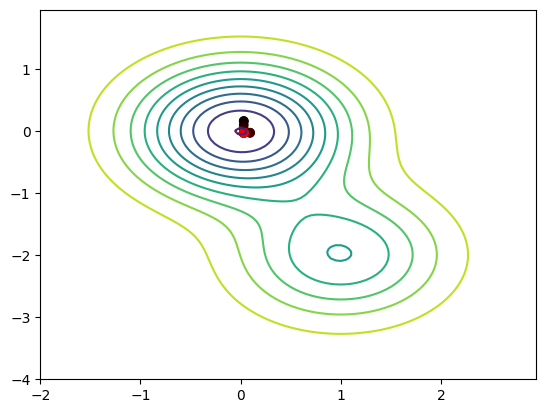

In [ ]:
ga = GeneticAlgorithm(chromosome_length=16, obj_func_num_args=2, objective_function=function, mutation_probability=0.1, population_size=1000, num_steps=20, aoi=[-8, 8])
ga.run()

## Badanie nr 3:
*  Rozmiar populacji : 1000
*  Ilość generacji :  20
*  Prawdopodobieństwo mutacji : 0.05
*  Długość chromoosmu : 32

Generation:  0 Best individual:  [1 0 0 0 0 0 1 0 1 1 0 0 1 1 0 1 0 1 1 1 1 1 1 1 1 0 0 0 1 1 1 0] x:  0.1751735713740743 y:  -0.027710383764400603 Function value:  0.5257865176125859
Generation:  1 Best individual:  [0 1 1 1 1 1 1 0 0 1 0 1 1 1 1 1 1 0 0 0 0 0 1 1 0 0 0 1 1 1 1 0] x:  -0.1016861219195846 y:  0.1949492637521928 Function value:  0.5459943301330357
Generation:  2 Best individual:  [1 0 0 0 0 0 0 0 1 1 1 1 1 0 1 1 1 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0] x:  0.06140230411230618 y:  0.024048218509193475 Function value:  0.5008942997792178
Generation:  3 Best individual:  [1 0 0 0 0 0 0 0 1 1 1 1 1 0 1 1 1 0 0 0 0 0 0 0 1 1 0 0 0 0 1 1] x:  0.06140230411230618 y:  0.04773022049286624 Function value:  0.5029020069419485
Generation:  4 Best individual:  [0 1 1 1 1 1 1 1 0 1 1 1 0 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1] x:  -0.03479056992446772 y:  -0.0015869382772564222 Function value:  0.49805346288345664
Generation:  5 Best individual:  [0 1 1 1 1 1 1 1 0 1 1 1 0 0 0 1 0 1 1 1 1 1 1

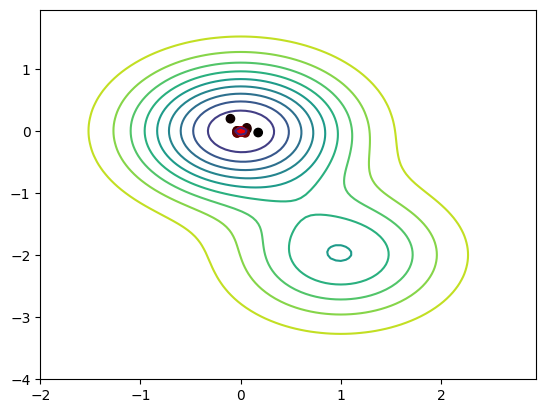

In [ ]:
ga = GeneticAlgorithm(chromosome_length=32, obj_func_num_args=2, objective_function=function, mutation_probability=0.1, population_size=1000, num_steps=20, aoi=[-8, 8])
ga.run()

## Badanie nr 4:
*  Rozmiar populacji : 1000
*  Ilość generacji :  20
*  Prawdopodobieństwo mutacji : 0.05
*  Długość chromoosmu : 4

Generation:  0 Best individual:  [1 0 0 1] x:  2.666666666666666 y:  -2.666666666666667 Function value:  1.4800661502519905
Generation:  1 Best individual:  [1 0 0 1] x:  2.666666666666666 y:  -2.666666666666667 Function value:  1.4800661502519905
Generation:  2 Best individual:  [1 0 0 1] x:  2.666666666666666 y:  -2.666666666666667 Function value:  1.4800661502519905
Generation:  3 Best individual:  [1 0 0 1] x:  2.666666666666666 y:  -2.666666666666667 Function value:  1.4800661502519905
Generation:  4 Best individual:  [1 0 0 1] x:  2.666666666666666 y:  -2.666666666666667 Function value:  1.4800661502519905
Generation:  5 Best individual:  [1 0 0 1] x:  2.666666666666666 y:  -2.666666666666667 Function value:  1.4800661502519905
Generation:  6 Best individual:  [1 0 0 1] x:  2.666666666666666 y:  -2.666666666666667 Function value:  1.4800661502519905
Generation:  7 Best individual:  [1 0 0 1] x:  2.666666666666666 y:  -2.666666666666667 Function value:  1.4800661502519905
Generati

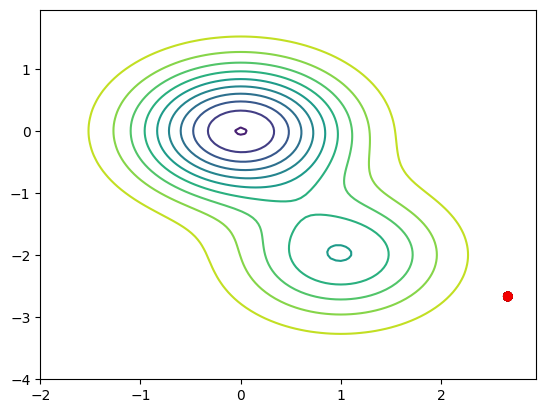

In [ ]:
ga = GeneticAlgorithm(chromosome_length=4, obj_func_num_args=2, objective_function=function, mutation_probability=0.1, population_size=1000, num_steps=20, aoi=[-8, 8])
ga.run()

# **Wnioski**
Jak widzimy na wyżej zamieszczonych wykresach, długość chromosomu ma bardzo duże znaczenie na poprawne działanie algorytmu genetycznego

Dziej się tak ponieważ z każdego chromosomu wyciągmay po 2 wartości, więc połowa długości chromosomu odpowiada za jeden argument dla funkcji

Jeśli mamy krótki chromosomy np. o długości 4, to 2 bity będą odpowiedzialne za wartość, która następnie zostanie przeskalowana na wartość w **aoi**, więc będzie niedokładna, a zależy to też od skali jaką przyjmiemy w aoi

Natomiast dla długich chromosomów, takich o długości np. 32, to za jeden argument odpowiada aż 16 bitów, czyli mamy większą precyzję w skalowaniu do nowych wartości zawartych w **aoi**

**Więc długość chromosomu ma bardzo duże znaczenie**
Jeżeli chcemy pracować na małych długościach warto przeskalować aoi do mniejszych wartości, jednakże dla dokładności lepiej mieć długie chormosomy i w miarę dobre aoi

--------------------------------------------------------------------------------

# Badanie rozmiaru kroku, na poprawne działanie algorytmu genetycznego
Będziemy pracować na średnim rozmiarze populacji, żeby lepiej pokazać wpływ ilości generacji

## Badanie nr 1 :
*  Rozmiar populacji : 600
*  Ilość generacji :  3
*  Prawdopodobieństwo mutacji : 0.05
*  Długość chromoosmu : 16


Generation:  0 Best individual:  [1 0 0 0 0 0 1 0 0 1 1 1 1 1 1 1] x:  0.15686274509803866 y:  -0.03137254901960773 Function value:  0.5201706374195857
Generation:  1 Best individual:  [1 0 0 0 0 0 1 0 0 1 1 1 1 1 1 1] x:  0.15686274509803866 y:  -0.03137254901960773 Function value:  0.5201706374195857
Generation:  2 Best individual:  [1 0 0 0 0 0 1 0 0 1 1 1 1 1 1 1] x:  0.15686274509803866 y:  -0.03137254901960773 Function value:  0.5201706374195857


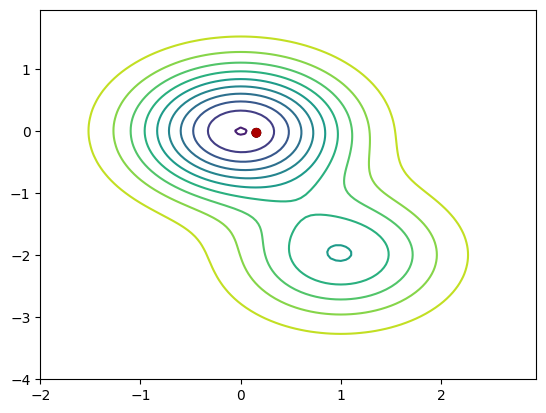

In [ ]:
ga = GeneticAlgorithm(chromosome_length=16, obj_func_num_args=2, objective_function=function, mutation_probability=0.05, population_size=600, num_steps=3, aoi=[-8, 8])
ga.run()

## Badanie nr 2 :
*  Rozmiar populacji : 600
*  Ilość generacji :  9
*  Prawdopodobieństwo mutacji : 0.05
*  Długość chromoosmu : 16

Generation:  0 Best individual:  [1 0 0 0 0 0 0 1 0 1 1 1 1 1 1 1] x:  0.0941176470588232 y:  -0.03137254901960773 Function value:  0.5052287588151285
Generation:  1 Best individual:  [1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1] x:  0.0941176470588232 y:  0.0941176470588232 Function value:  0.5148183377639026
Generation:  2 Best individual:  [1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1] x:  0.0941176470588232 y:  0.0941176470588232 Function value:  0.5148183377639026
Generation:  3 Best individual:  [1 0 0 0 0 0 0 1 0 1 1 1 1 1 1 0] x:  0.0941176470588232 y:  -0.0941176470588232 Function value:  0.5117385212023122
Generation:  4 Best individual:  [1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0] x:  0.0941176470588232 y:  0.03137254901960773 Function value:  0.5062420907205353
Generation:  5 Best individual:  [1 0 0 0 0 0 0 1 0 1 1 1 1 1 1 1] x:  0.0941176470588232 y:  -0.03137254901960773 Function value:  0.5052287588151285
Generation:  6 Best individual:  [1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 0] x:  0.03137254901960773 y:  -0.09

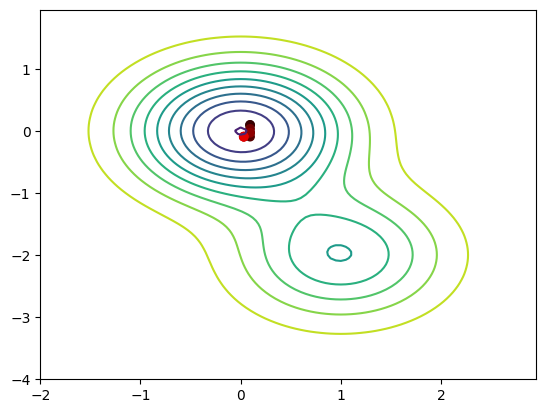

In [ ]:
ga = GeneticAlgorithm(chromosome_length=16, obj_func_num_args=2, objective_function=function, mutation_probability=0.05, population_size=600, num_steps=9, aoi=[-8, 8])
ga.run()

## Badanie nr 3 :
*  Rozmiar populacji : 600
*  Ilość generacji :  20
*  Prawdopodobieństwo mutacji : 0.05
*  Długość chromoosmu : 16

Generation:  0 Best individual:  [1 0 0 0 0 0 0 1 1 0 0 0 0 1 0 0] x:  0.0941176470588232 y:  0.28235294117647136 Function value:  0.5835682756522481
Generation:  1 Best individual:  [1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0] x:  0.03137254901960773 y:  -0.219607843137255 Function value:  0.5398005398101668
Generation:  2 Best individual:  [1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 0] x:  0.03137254901960773 y:  -0.0941176470588232 Function value:  0.5046183554293575
Generation:  3 Best individual:  [1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1] x:  0.03137254901960773 y:  -0.03137254901960773 Function value:  0.4979077879999493
Generation:  4 Best individual:  [1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1] x:  0.03137254901960773 y:  -0.03137254901960773 Function value:  0.4979077879999493
Generation:  5 Best individual:  [1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 0] x:  0.03137254901960773 y:  -0.0941176470588232 Function value:  0.5046183554293575
Generation:  6 Best individual:  [1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 0] x:  0.03137254901960773 y: 

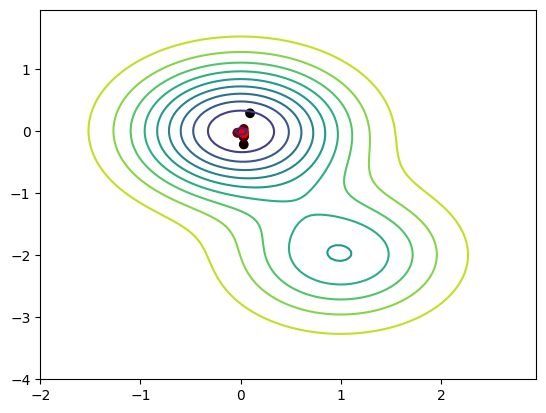

In [ ]:
ga = GeneticAlgorithm(chromosome_length=16, obj_func_num_args=2, objective_function=function, mutation_probability=0.05, population_size=600, num_steps=20, aoi=[-8, 8])
ga.run()

## Badanie nr 4 :
*  Rozmiar populacji : 600
*  Ilość generacji :  50
*  Prawdopodobieństwo mutacji : 0.05
*  Długość chromoosmu : 16

Generation:  0 Best individual:  [1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0] x:  0.03137254901960773 y:  0.03137254901960773 Function value:  0.4988086776680487
Generation:  1 Best individual:  [1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1] x:  0.03137254901960773 y:  0.0941176470588232 Function value:  0.5073564266429198
Generation:  2 Best individual:  [1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1] x:  0.03137254901960773 y:  0.0941176470588232 Function value:  0.5073564266429198
Generation:  3 Best individual:  [1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1] x:  0.03137254901960773 y:  0.0941176470588232 Function value:  0.5073564266429198
Generation:  4 Best individual:  [0 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1] x:  -0.03137254901960773 y:  -0.2823529411764705 Function value:  0.5685063186084325
Generation:  5 Best individual:  [0 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1] x:  -0.03137254901960773 y:  -0.15686274509803955 Function value:  0.5194894330021667
Generation:  6 Best individual:  [1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1] x:  0.0941176470588232 y:  

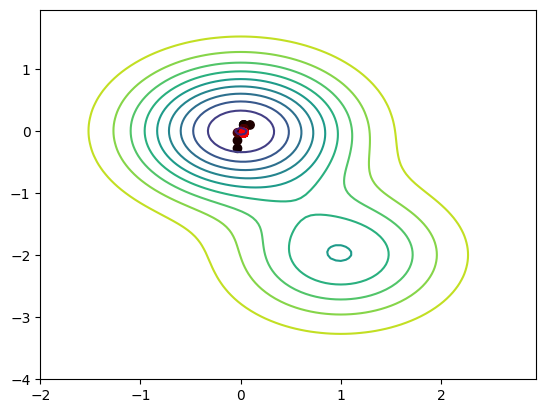

In [ ]:
ga = GeneticAlgorithm(chromosome_length=16, obj_func_num_args=2, objective_function=function, mutation_probability=0.05, population_size=600, num_steps=50, aoi=[-8, 8])
ga.run()

# **Wnioski**
Jak widzimy ilość kroków ma znaczenie na poprawne działanie algorytmu, ponieważ od ilości kroków tj. tworzenia nowych generacji zależy czy algorytm zdąży na tyle wyewoluować, aby coraz bardziej zagęszczać się wokół minimum funkcji i coraz więcej chromosomów przyjmowało minimalne wartości

Oczywiście na poprawne działanie całego algorytmu mają wpływ wszystkie wartości dobierane w algorytmie. Dlatego najlepsze działanie algorytmu zapewnią nam dobrze dobrane długości choromosomó (najlepiej duże), duża ilość osobników w populacji oraz duża ilość kroków (ale niekoniecznie bardzo duża, ponieważ od pewnego momentu generacje zwracają ciągle tego samego osobnika jako osobnika o najmniejszej wartości)

# Względem Gradient Descent

Do szukania minimum funkcji lepszy okazuje się algorytm genetyczny, ponieważ przy losowaniu może już w 1 iteracji znaleźć minimum i się już go trzymać. Dodatkowo,jeżeli w algorytmie gradient_descent użyjemy za małego kroku, to istnieje szansa że nie wyjdzie on z minimum lokalnego, gdzie algorytm genetyczny może wylosować nowy punkt, który wyjdzie z minimum
